In [1]:
# importing libraries
import joblib
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import matplotlib
matplotlib.use("Qt5Agg")
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 170)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
# functions

def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

def cat_summary(dataframe, col_name, plot=False):

    if dataframe[col_name].dtypes == "bool":
        dataframe[col_name] = dataframe[col_name].astype(int)

        print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                            "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
        print("##########################################")

        if plot:
            sns.countplot(x=dataframe[col_name], data=dataframe)
            plt.show(block=True)
    else:
        print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                            "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
        print("##########################################")

        if plot:
            sns.countplot(x=dataframe[col_name], data=dataframe)
            plt.show(block=True)

def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist()
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

def grab_col_names(dataframe, cat_th=10,  car_th=20):
    """
    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.

    Parameters
    ----------
    dataframe: dataframe
        değişken isimleri alınmak istenen dataframe'dir.
    cat_th: int, float
        numerik fakat kategorik olan değişkenler için sınıf eşik değeri
    car_th: int, float
        kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    -------
    cat_cols: list
        Kategorik değişken listesi
    num_cols: list
        Numerik değişken listesi
    cat_but_car: list
        Kategorik görünümlü kardinal değişken listesi

    Notes
    ------
    cat_cols + num_cols + cat_but_car = toplam değişken sayısı
    num_but_cat cat_cols'un içerisinde.

    """
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ["category", "object", "bool"]]

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes in ["int", "float", "int64", "float64"]]

    cat_but_car = [col for col in df.columns if
                   dataframe[col].nunique() > car_th and str(dataframe[col].dtypes) in ["category", "object"]]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes in ["int", "float"]]
    num_cols = [col for col in num_cols if col not in cat_cols]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car

def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")

def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns

def missing_vs_target(dataframe, target, na_columns):
    temp_df = dataframe.copy()
    for col in na_columns:
        temp_df[col + '_NA_FLAG'] = np.where(temp_df[col].isnull(), 1, 0)
    na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns
    for col in na_flags:
        print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                            "Count": temp_df.groupby(col)[target].count()}), end="\n\n\n")



In [3]:
# Reading data

cpu = pd.read_csv("cpu.csv")
df = cpu.copy()

In [4]:
check_df(df)

##################### Shape #####################
(875, 12)
##################### Types #####################
company         object
name            object
codename        object
cores            int64
threads          int64
base_clock     float64
boost_clock    float64
socket          object
process          int64
l3_cache       float64
tdp              int64
released        object
dtype: object
##################### Head #####################
  company           name  codename  cores  threads  base_clock  boost_clock socket  process  l3_cache  tdp    released
0   Intel  Pentium E5500  Wolfdale      2        2       2.800          NaN    775       45       NaN   65  2010-04-18
1   Intel  Pentium E6700  Wolfdale      2        2       3.200          NaN    775       45       NaN   65  2010-05-30
2   Intel  Pentium E5700  Wolfdale      2        2       3.000          NaN    775       45       NaN   65  2010-08-08
3   Intel  Celeron E3500  Wolfdale      2        2       2.700          NaN

In [5]:
df.drop_duplicates(subset=["name"], inplace=True)

In [6]:
df["released"].head()
df["released"].dtype

dtype('O')

In [7]:
df.loc[df["released"].isnull(), :]

,company,name,codename,cores,threads,base_clock,boost_clock,socket,process,l3_cache,tdp,released
836,Intel,Core i9-10875H,Comet Lake-H,8,16,2.100,5.100,BGA1440,14,12.000,45,NaN
837,Intel,Core i9-10980HK,Comet Lake-H,8,16,2.400,5.300,BGA1440,14,12.000,45,NaN


In [8]:
# correcting some mistakes in the data

df.loc[df.index == 836, "name"] = "Core i7-10875H"
df.loc[df.index == 836, "base_clock"] = 2.300
df.loc[df.index == 836, "released"] = "2020-04-02"

df.loc[df.index == 837, "released"] = "2020-04-02"

In [9]:
# format to proper type
df["released"] = pd.to_datetime(df["released"], format="%Y/%m/%d")

In [10]:
# creating new column called "year" out of "released" column

df["year"] = df["released"].dt.year

In [11]:
# creating new column with year and month

df["release_date"] = pd.to_datetime(df["released"]).dt.to_period("M")

In [12]:
# I saw CPU manufacturers announcing their release date as quarter type so

df["release_date"] = df["released"].dt.to_period("Q")

In [13]:
df["release_date"].head()

0    2010Q2
1    2010Q2
2    2010Q3
3    2010Q3
4    2010Q3
Name: release_date, dtype: period[Q-DEC]

In [14]:
df.groupby("release_date").agg({
    "tdp":"mean"
})

# Ones that show high tdp (over 100) makes me curious whether or not the processors in these periods are more towards
# work stations. Gonna take a look at them later


,tdp
release_date,
2010Q1,102.500
2010Q2,59.237
2010Q3,53.488
2010Q4,49.286
2011Q2,50.450
2011Q3,48.361
2011Q4,64.634
2012Q3,36.923
2012Q4,97.772


In [15]:
## Functions to create new features out of suffixes of cpu names

def amd_efficient(name):
    if name.endswith("E"):
        return "efficient"
    elif name.endswith("GE"):
        return "efficient"
    else:
        pass

def amd_mobile(name):
    if name.endswith("H"):
        return "mobile"
    elif name.endswith("HS"):
        return "mobile"
    elif name.endswith("U"):
        return "mobile"
    else:
        pass

def amd_work_station(name):
    if name.endswith("WX"):
        return "work station"
    else:
        pass

def intel_power_optimized(name):
    if name.endswith("T"):
        return "efficient"
    elif name.endswith("U"):
        return "efficient"
    elif name.endswith("Y"):
        return "efficient"
    else:
        pass

def intel_mobile(name):
    if name.endswith("H"):
        return "mobile"
    elif name.endswith("HK"):
        return "mobile"
    elif name.endswith("HQ"):
        return "mobile"
    else:
        pass

In [16]:
## Applying functions and holding indexes along with creating new features

df["new_type"] = df.loc[df["company"] == "AMD", "name"].apply(lambda x: amd_efficient(x))
eff_1 = df[df["new_type"] == "efficient"].index

df["new_type"] = df.loc[df["company"] == "AMD", "name"].apply(lambda x: amd_mobile(x))
df["new_type"] = df.loc[df["company"] == "Intel", "name"].apply(lambda x: intel_mobile(x))
mob_1 = df[df["new_type"] == "mobile"].index

df["new_type"] = df.loc[df["company"] == "AMD", "name"].apply(lambda x: amd_work_station(x))
wx_1 = df[df["new_type"] == "work station"].index

df["new_type"] = df.loc[df["company"] == "Intel", "name"].apply(lambda x: intel_power_optimized(x))
eff_2 = df[df["new_type"] == "efficient"].index


In [17]:
mob_1 = [493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523,
            524, 797, 798, 799, 800, 801, 802, 803, 804, 805, 827, 836, 837, 838, 839, 840, 841, 843, 845, 846, 847, 848]

In [18]:
df.loc[eff_1, "new_type"] = "efficient"
df.loc[mob_1, "new_type"] = "mobile"
df.loc[wx_1, "new_type"] = "work station"
df.loc[eff_2, "new_type"] = "efficient"

In [19]:
indexes = list(eff_1) + list(eff_2) + list(mob_1) + list(wx_1)
indexes = pd.Index(indexes)

In [20]:
## Everything else goes to "desktop" category although we'll dive a bit more into it.

df.loc[df.index.isin(indexes) == False, "new_type"] = "desktop"

In [21]:
## Taking a look at the periods that I suspect more processors for workstation and correctly classifying them if any.

df.loc[df["release_date"] == "2019Q4", ["company", "name", "codename", "tdp"]]

,company,name,codename,tdp
145,Intel,Core i9-9900KS,Coffee Lake-R,127
274,Intel,Core i9-10940X,Cascade Lake-X,165
276,Intel,Core i9-10920X,Cascade Lake-X,165
278,Intel,Core i9-10900X,Cascade Lake-X,165
284,Intel,Core i9-10980XE,Cascade Lake-X,165
396,AMD,Athlon 3000G,Zen,35
432,AMD,Ryzen 9 3950X,Matisse,105
668,AMD,Ryzen Threadripper 3980X,Matisse,280
670,AMD,Ryzen Threadripper 3970X,Matisse,280
671,AMD,Ryzen Threadripper 3960X,Matisse,280


In [22]:
df.loc[df["codename"] == "Matisse", "new_type"] = "work station"
df.loc[df["codename"] == "Cascade Lake-X", "new_type"] = "work station"

In [23]:
df.loc[df["release_date"] == "2018Q4", ["company", "name", "codename", "tdp"]]

,company,name,codename,tdp
127,Intel,Core i5-9400,Coffee Lake,65
128,Intel,Core i5-9500,Coffee Lake,65
129,Intel,Core i5-9600,Coffee Lake,65
130,Intel,Core i5-9600K,Coffee Lake,95
138,Intel,Core i7-9700K,Coffee Lake,95
142,Intel,Core i9-9900K,Coffee Lake-R,95
269,Intel,Core i9-9820X,Skylake-X,165
270,Intel,Core i7-9800X,Skylake-X,165
272,Intel,Core i9-9940X,Skylake-X,165
273,Intel,Core i9-9990XE,Skylake-X,255


In [24]:
df.loc[df["codename"] == "Cascade Lake-SP", "new_type"] = "work station"
df.loc[df["codename"] == "Skylake-X", "new_type"] = "work station"
df.loc[df["codename"] == "Skylake-W", "new_type"] = "work station"

In [25]:
df.loc[df["release_date"] == "2017Q2", ["company", "name", "codename", "tdp"]]

,company,name,codename,tdp
263,Intel,Core i5-7640X,Kaby Lake-X,112
264,Intel,Core i7-7740X,Kaby Lake-X,112
265,Intel,Core i7-7800X,Skylake-X,140
266,Intel,Core i7-7820X,Skylake-X,140
267,Intel,Core i9-7900X,Skylake-X,140
398,AMD,Ryzen 5 1400,Zen,65
399,AMD,Ryzen 3 1300,Zen,65
400,AMD,Ryzen 3 PRO 1200,Zen,65
401,AMD,Ryzen 3 PRO 1300,Zen,65
407,AMD,Ryzen 7 PRO 1700,Zen,65


In [26]:
df.loc[df["codename"] == "Naples", "new_type"] = "work station"

In [27]:
df.loc[df["release_date"] == "2016Q2", ["company", "name", "codename", "tdp"]]

,company,name,codename,tdp
301,Intel,Xeon Phi 7290,Knights Landing,245
302,Intel,Xeon Phi 7290F,Knights Landing,260
304,Intel,Xeon Phi 7250,Knights Landing,215
305,Intel,Xeon Phi 7250F,Knights Landing,230
307,Intel,Xeon Phi 7210,Knights Landing,215
308,Intel,Xeon Phi 7210F,Knights Landing,230
309,Intel,Xeon Phi 7230,Knights Landing,215
310,Intel,Xeon Phi 7230F,Knights Landing,230
314,Intel,Core i7-6800K,Broadwell-E,140
315,Intel,Core i7-6850K,Broadwell-E,140


In [28]:
df.loc[df["codename"] == "Knights Landing", "new_type"] = "work station"

In [29]:
df.loc[df["release_date"] == "2013Q2", ["company", "name", "codename", "tdp"]]

,company,name,codename,tdp
730,Intel,Core i5-4350U,Haswell,15
742,Intel,Core i7-4650U,Haswell-ULT,15
743,Intel,Core i7-4500U,Haswell-ULT,15
797,Intel,Core i7-4950HQ,Crystalwell,47
865,Intel,Xeon Phi 7120P,Knights Corner,300
866,Intel,Xeon Phi 7120X,Knights Corner,300
868,Intel,Xeon Phi 3120A,Knights Corner,300
869,Intel,Xeon Phi 3120P,Knights Corner,300
870,Intel,Xeon Phi 31S1P,Knights Corner,270
874,Intel,Xeon Phi 5120D,Knights Corner,245


In [30]:
df.loc[df["codename"] == "Knights Corner", "new_type"] = "work station"

In [31]:
df.loc[:, "new_type"].value_counts()

desktop         597
efficient       127
work station     82
mobile           53
Name: new_type, dtype: int64

In [32]:
df.groupby("new_type").agg({
    "tdp":"mean"
})

,tdp
new_type,
desktop,72.739
efficient,35.480
mobile,33.019
work station,195.366


In [33]:
pd.DataFrame(df.groupby("company")["new_type"].value_counts())

new_type
company new_type              
AMD     desktop            210
        mobile              32
        efficient           30
        work station        29
Intel   desktop            387
        efficient           97
        work station        53
        mobile              21

In [34]:
target_summary_with_cat(df, "tdp", "year")

      TARGET_MEAN
year             
2010       58.071
2011       55.670
2012       73.052
2013       76.071
2014       57.433
2015       58.889
2016      123.591
2017       97.168
2018       84.626
2019       95.573
2020       85.022




In [35]:
target_summary_with_cat(df, "tdp", "company")

         TARGET_MEAN
company             
AMD           86.146
Intel         71.274




In [36]:
for i in list(df["year"].unique()):
    print(df.loc[df["year"] == i, ["company", "tdp"]].groupby("company").agg({"tdp": "mean"}))
    print("YEAR: " + str(i))

           tdp
company       
AMD     81.316
Intel   43.590
YEAR: 2010
            tdp
company        
AMD     118.600
Intel    73.809
YEAR: 2013
           tdp
company       
AMD     75.571
Intel   55.038
YEAR: 2014
            tdp
company        
AMD     110.000
Intel    56.512
YEAR: 2015
           tdp
company       
AMD     96.481
Intel   97.957
YEAR: 2017
           tdp
company       
AMD     81.613
Intel   86.000
YEAR: 2018
            tdp
company        
AMD     116.213
Intel    75.776
YEAR: 2019
           tdp
company       
AMD     68.617
Intel   43.500
YEAR: 2011
           tdp
company       
AMD     79.186
Intel   68.075
YEAR: 2012
           tdp
company       
AMD     77.333
Intel   90.148
YEAR: 2020
            tdp
company        
AMD      30.444
Intel   188.077
YEAR: 2016


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 859 entries, 0 to 874
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   company       859 non-null    object        
 1   name          859 non-null    object        
 2   codename      859 non-null    object        
 3   cores         859 non-null    int64         
 4   threads       859 non-null    int64         
 5   base_clock    859 non-null    float64       
 6   boost_clock   551 non-null    float64       
 7   socket        859 non-null    object        
 8   process       859 non-null    int64         
 9   l3_cache      674 non-null    float64       
 10  tdp           859 non-null    int64         
 11  released      859 non-null    datetime64[ns]
 12  year          859 non-null    int64         
 13  release_date  859 non-null    period[Q-DEC] 
 14  new_type      859 non-null    object        
dtypes: datetime64[ns](1), float64(3), int64(

In [38]:
df["release_date_str"] = df["release_date"].astype("string")

In [39]:
df.rename(columns={"new_type":"type"}, inplace=True)

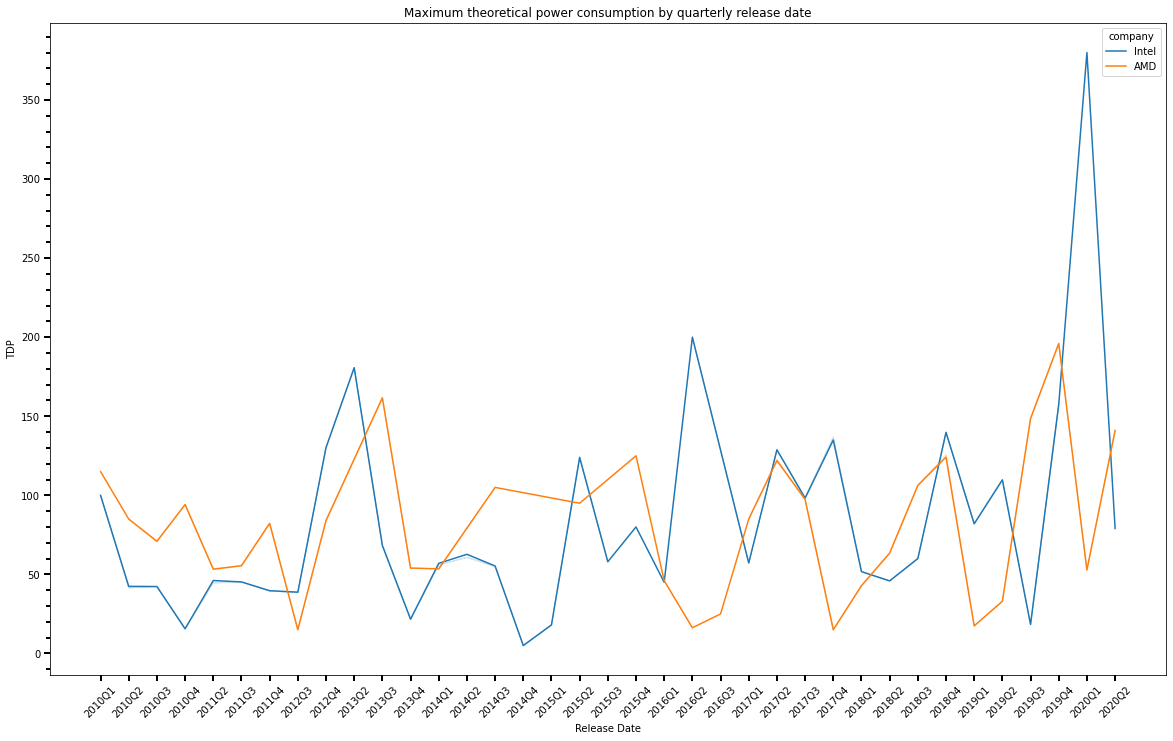

In [40]:
fig = plt.figure(figsize=(20,12))
g = sns.lineplot(data = df.sort_values(by="release_date_str"),x="release_date_str", y="tdp", hue="company", ci=False)
g.yaxis.set_minor_locator(AutoMinorLocator(5))
g.set_title("Maximum theoretical power consumption by quarterly release date")
g.set_ylabel("TDP")
g.set_xlabel("Release Date")
g.tick_params(which="both", width=2)
g.tick_params(which="major", length=6)
g.tick_params(which="minor", length=4)
g.tick_params(axis="x", rotation=45)

fig.savefig("linepl_2.png", dpi=300)

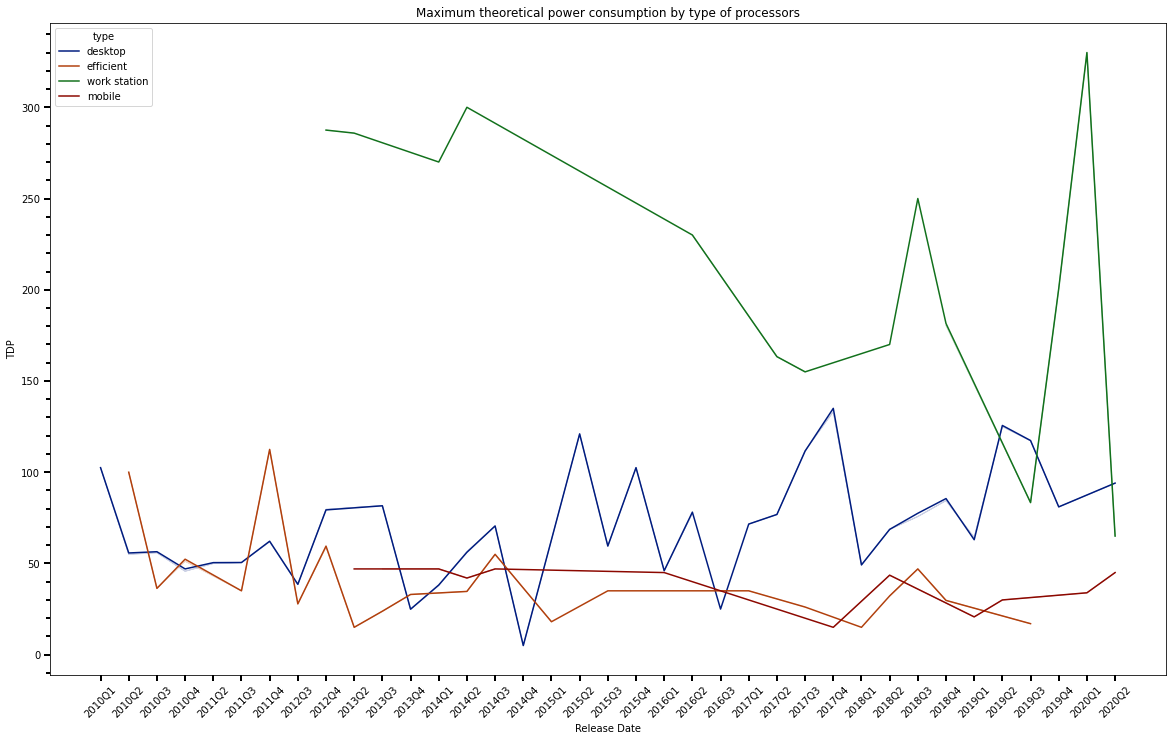

In [41]:
fig = plt.figure(figsize=(20,12))
g = sns.lineplot(data = df.sort_values(by="release_date_str"),x="release_date_str", y="tdp", hue="type", ci=False,
                palette="dark")
g.yaxis.set_minor_locator(AutoMinorLocator(5))
g.set_title("Maximum theoretical power consumption by type of processors")
g.set_ylabel("TDP")
g.set_xlabel("Release Date")
g.tick_params(which="both", width=2)
g.tick_params(which="major", length=6)
g.tick_params(which="minor", length=4)
g.tick_params(axis="x", rotation=45)

fig.savefig("line_pl.png", dpi=300)

In [42]:
df_sorted = df.sort_values(by="release_date_str")

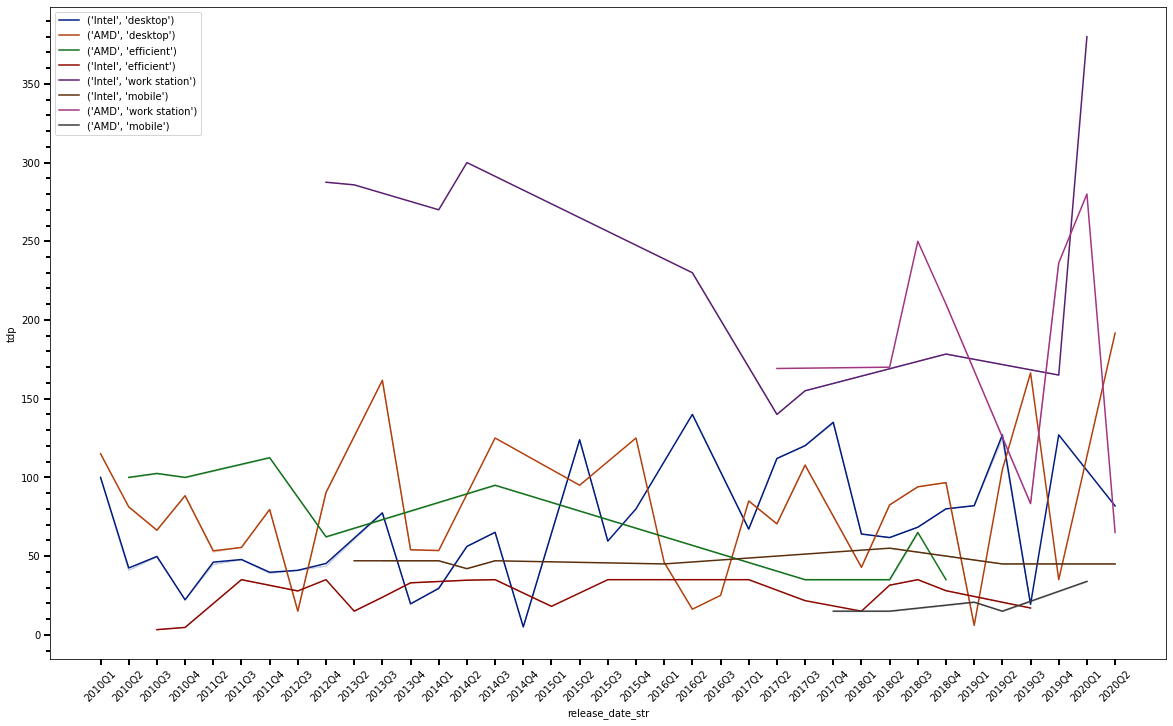

In [43]:
fig = plt.figure(figsize=(20,12))
g = sns.lineplot(x=df_sorted["release_date_str"], y=df_sorted["tdp"], hue=df_sorted[['company', 'type']].apply(tuple, axis=1), 
                 ci=False, palette="dark")
g.yaxis.set_minor_locator(AutoMinorLocator(5))
g.tick_params(which="both", width=2)
g.tick_params(which="major", length=6)
g.tick_params(which="minor", length=4)
g.tick_params(axis="x", rotation=45)

fig.savefig("linepl_hue", dpi=300)

In [44]:
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.2f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center")
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.2f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

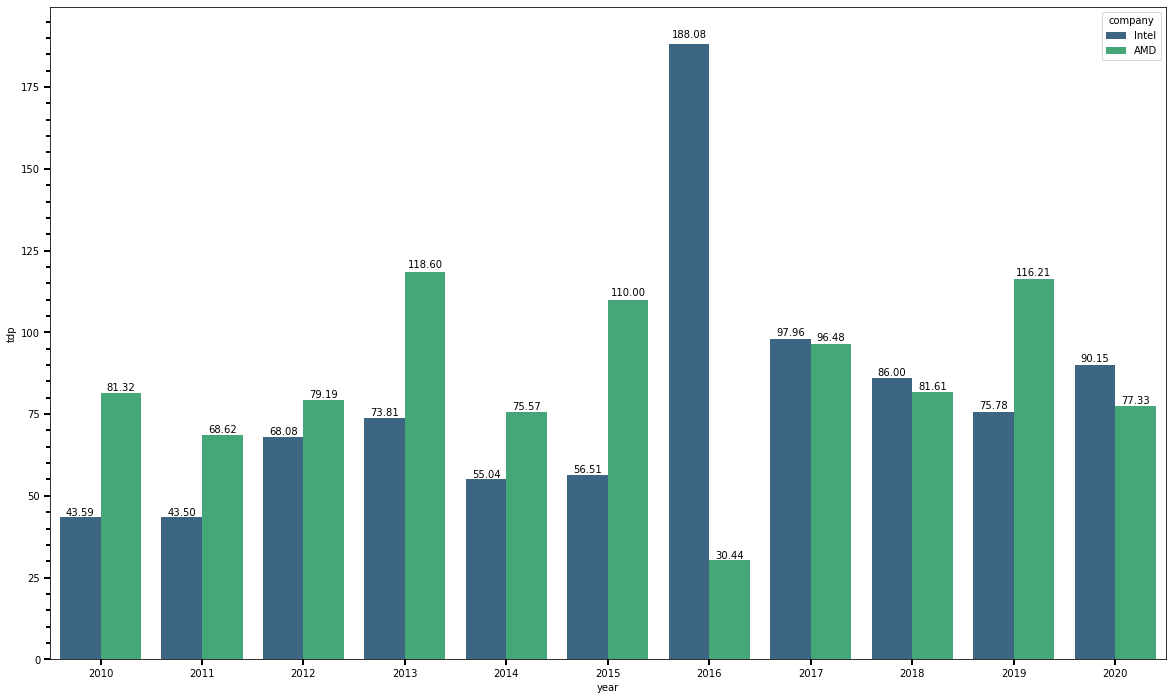

In [45]:
fig = plt.figure(figsize=(20,12))
g = sns.barplot(x=df["year"], y=df["tdp"], hue="company", data=df, ci=False, palette="viridis")
show_values(g)
g.yaxis.set_minor_locator(AutoMinorLocator(5))
g.tick_params(which="both", width=2)
g.tick_params(which="major", length=6)
g.tick_params(which="minor", length=4)

fig.savefig("tdp_yearly", dpi=300)

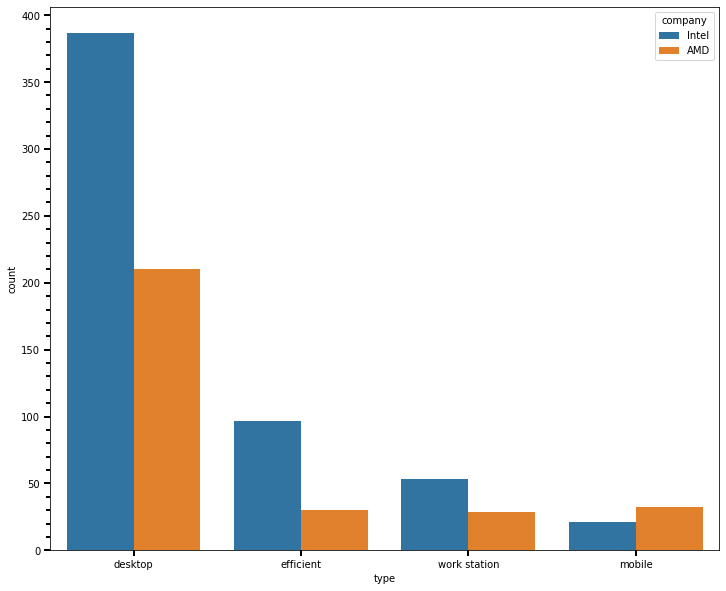

In [46]:
fig = plt.figure(figsize=(12,10))
g = sns.countplot(x=df["type"], hue=df["company"])
g.yaxis.set_minor_locator(AutoMinorLocator(5))
g.tick_params(which="both", width=2)
g.tick_params(which="major", length=6)
g.tick_params(which="minor", length=4)

fig.savefig("type_company.png", dpi=300)

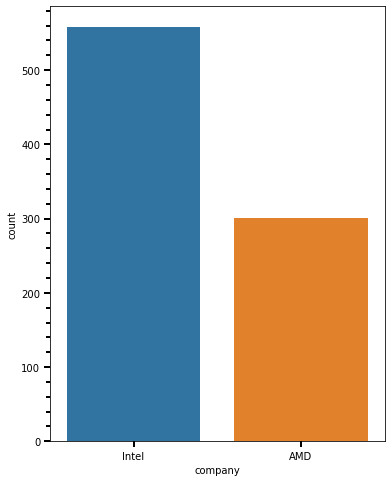

In [47]:
fig = plt.figure(figsize=(6,8))
g = sns.countplot(x=df.company)
g.yaxis.set_minor_locator(AutoMinorLocator(5))
g.tick_params(which="both", width=2)
g.tick_params(which="major", length=6)
g.tick_params(which="minor", length=4)

fig.savefig("companycount.png", dpi=300)

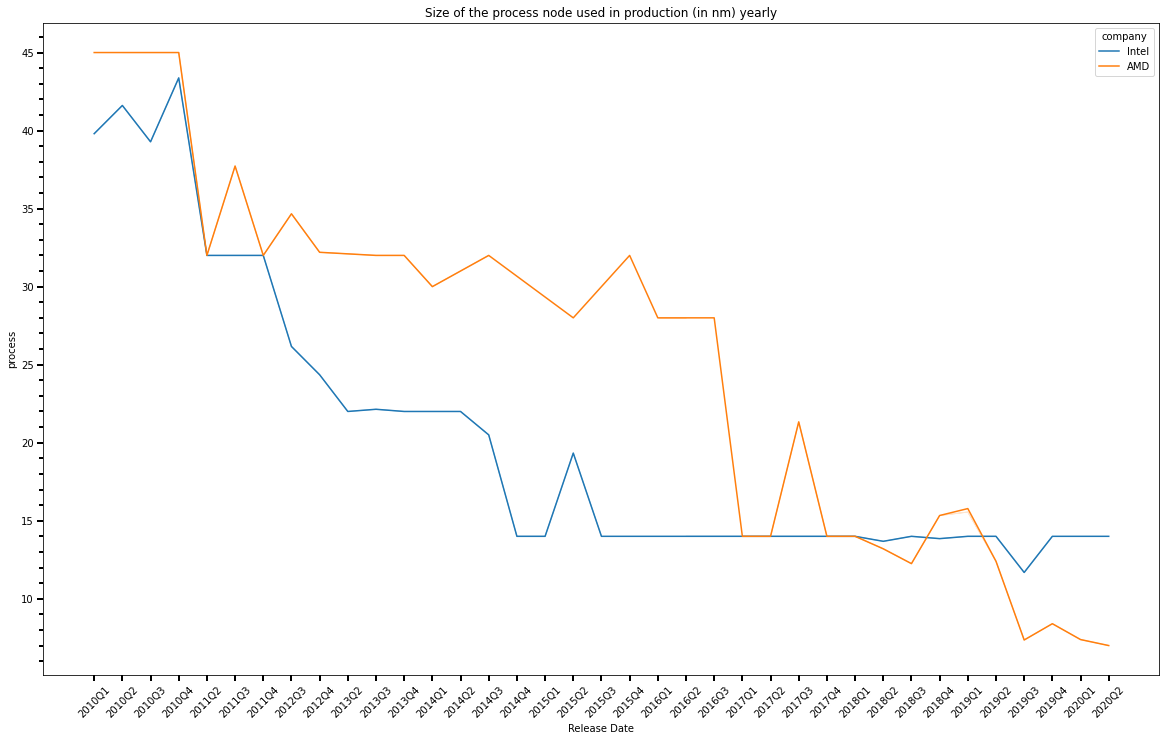

In [50]:
fig = plt.figure(figsize=(20,12))
g = sns.lineplot(data = df.sort_values(by="release_date_str"),x="release_date_str", y="process", hue="company", ci=False)
g.yaxis.set_minor_locator(AutoMinorLocator(5))
g.set_title("Size of the process node used in production (in nm) yearly")
g.set_xlabel("Release Date")
g.tick_params(which="both", width=2)
g.tick_params(which="major", length=6)
g.tick_params(which="minor", length=4)
g.tick_params(axis="x", rotation=45)

fig.savefig("processize.png", dpi=300)